In [227]:
import scanpy as sc
import scvi
import covbat

import warnings
#warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import numpy.random
import pingouin as pg
import anndata
import sklearn
import sklearn.metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
import patsy

import rpy2.robjects as ro
from rpy2.robjects.packages import importr
kbet = importr('kBET')
from rpy2.robjects import pandas2ri
pandas2ri.activate()
neuroCombat = importr('neuroCombat')
lisi = importr('lisi')

import dill

In [4]:
scale = 1000000
adni_all = pd.read_csv("/home/fengling/Documents/nnbatch/data/raw/ADNI_ANTsSST_protocol_2019_03_14.csv")
adni_all["site"] = adni_all["site"].astype("category")
#adni_all = adni_all.loc[adni_all.VISIT == 0] # Select only primary visit
adni_x = adni_all.iloc[:, 42:].reset_index(drop = True)
adni_obsm = adni_all.iloc[:, 0:42].reset_index(drop = True)
adata = sc.AnnData(X = adni_x, obs = adni_obsm)
adata.layers["raw"] = adata.X.copy()
adata.layers["scaled"] = np.round(adata.X.copy() * scale)

/home/fengling/software/pkg/mamba/envs/nnbatch-env/lib/python3.9/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [181]:
def plot_pca_umap(adata, layer_key: str, umap_min_dist: float, color: list, 
                  use_obsm = False):
    if use_obsm:
        adata_tmp = sc.AnnData(X = adata.obsm[layer_key], obs = adata.obs)
    else:
        adata_tmp = adata.copy()
        if layer_key != "X":
            adata_tmp.X = adata_tmp.layers[layer_key]
    pc_num = min([adata_tmp.X.shape[1] - 1, 50])
    sc.tl.pca(adata_tmp, svd_solver='arpack', n_comps = pc_num)
    sc.pp.neighbors(adata_tmp, n_pcs = pc_num, n_neighbors = 10)
    sc.tl.umap(adata_tmp, min_dist = umap_min_dist, maxiter = 500)
    print("Plots for: " + layer_key)
    print("UMAP")
    sc.pl.umap(adata_tmp,
           color = color,
           frameon = False,)
    print("PCA")
    sc.pl.pca(adata_tmp, 
          color = color,
         frameon = False)

# def evaluate_cluster_metrics(adata, layer_key: str, batch_key: str, 
#                           shuffle_y = False, verbose = False, 
#                           use_obsm = False) -> list:
#     if use_obsm:
#         adata_tmp = sc.AnnData(X = adata.obsm[layer_key], obs = adata.obs)
#     else:
#         adata_tmp = adata.copy()
#         if layer_key != "X":
#             adata_tmp.X = adata_tmp.layers[layer_key]
#     x = adata_tmp.X.copy()
#     y = adata_tmp.obs[batch_key].copy().to_numpy()
#     if shuffle_y:
#         if verbose:
#             print("Calculating metrics under the null for: " + batch_key)
#         numpy.random.shuffle(y)
#     if verbose:
#         print("Calculating metrics for: " + batch_key)
#     xy_df = pd.DataFrame(x)
#     xy_df[batch_key] = y

#     # get random forest OOB for ability to predict batch_key
#     rf = RandomForestClassifier(n_estimators = 100, oob_score = True).fit(x, y)
#     rf_oob = rf.oob_score_
#     if verbose:
#         print("Random forest OOB: " + str(rf_oob))

#     # get ANOVA p-values
#     f_stats = []
#     for i in range(x.shape[1]):
#         f_stats.append(pg.anova(data = xy_df, dv = i, between = batch_key, detailed = True).F[0])
#     mean_f_stat = np.mean(f_stats)
#     if verbose:
#         print("Average ANOVA F-stat: " + str(mean_f_stat))
    
#     # get silhouette score
#     sil_score = sklearn.metrics.silhouette_score(x, labels = y)
#     if verbose:
#         print("Silhouette score: " + str(sil_score)
    
#     # get kBET results
#     r_x = ro.conversion.py2rpy(pd.DataFrame(x))
#     r_y = ro.conversion.py2rpy(y)
#     kbet_out = kbet.kBET(r_x, r_y, plot = False)
#     kbet_pval = kbet_out.rx("average.pval")[0][0]
#     if verbose:
#         print("kBET p-value is: " + str(kbet_pval))
    
#     metrics = [rf_oob, mean_f_stat, sil_score, kbet_pval]
#     return metrics

In [6]:
def evaluate_cluster_metrics(adata, layer_key: str, cluster_key: str, is_categorical = True,
                           shuffle_y = False, verbose = False, use_obsm = False):
    if use_obsm:
        adata_tmp = sc.AnnData(X = adata.obsm[layer_key], obs = adata.obs)
    else:
        adata_tmp = adata.copy()
        if layer_key != "X":
            adata_tmp.X = adata_tmp.layers[layer_key]
    x = adata_tmp.X.copy()
    y = adata_tmp.obs[cluster_key].copy().to_numpy()
    if shuffle_y:
        if verbose:
            print("Calculating metrics under the null for: " + cluster_key)
        numpy.random.shuffle(y)
    if verbose:
        print("Calculating metrics for: " + cluster_key)
    xy_df = pd.DataFrame(x)
    xy_df[cluster_key] = y
    
    # get random forest OOB for ability to predict batch_key
    if is_categorical:
        rf = RandomForestClassifier(n_estimators = 100, oob_score = True).fit(x, y)
        rf_oob = rf.oob_score_
    else:
        rf = RandomForestRegressor(oob_score = True).fit(x, y)
        rf_oob = rf.oob_score_
    if verbose:
        print("Random forest OOB: " + str(rf_oob))
    
    # get ANOVA p-values
    f_stats = []
    if is_categorical:
        for i in range(x.shape[1]):
            f_stats.append(pg.anova(data = xy_df, dv = i, between = cluster_key, detailed = True).F[0])
    else:
        for i in range(x.shape[1]):
            f_stats.append(np.absolute(pg.linear_regression(X = xy_df[cluster_key], y = xy_df.iloc[:, i])["T"][1]))
        r2 = pg.linear_regression(X = xy_df.iloc[:, 1:x.shape[1]], y = xy_df[cluster_key])["r2"][0]
    mean_f_stat = np.mean(f_stats)
    if verbose:
        print("Average ANOVA F-stat: " + str(mean_f_stat))
        if not is_categorical:
            print("R^2 is: " + str(r2))
    
    if not is_categorical:
        if verbose:
            print("")
        metrics = [rf_oob, mean_f_stat, r2]
        return metrics

    if is_categorical:
        # get silhouette score
        sil_score = sklearn.metrics.silhouette_score(x, labels = y)
        if verbose:
            print("Silhouette score: " + str(sil_score))
                  
        # get kBET results
        r_x = ro.conversion.py2rpy(pd.DataFrame(x))
        r_y = ro.conversion.py2rpy(y)
        kbet_out = kbet.kBET(r_x, r_y, plot = False)
        kbet_pval = kbet_out.rx("average.pval")[0][0]
        if verbose:
            print("kBET p-value is: " + str(kbet_pval))
                  
        # get LISI scores
        tmp_y = pd.DataFrame(pd.factorize(y)[0])
        r_y = ro.conversion.py2rpy(tmp_y.set_axis([cluster_key], axis = 1))
        lisi_out = np.mean(lisi.compute_lisi(r_x, r_y, label_colnames = cluster_key)).tolist()[0]
        if verbose:
            print("LISI score is: " + str(lisi_out))
    
    if verbose:
        print("")
    metrics = [rf_oob, mean_f_stat, sil_score, 1 / kbet_pval, 1 - lisi_out]
    return metrics

def evaluate_all_clusters(adata, layer_key_list: list, obsm_key_list: list, cluster_key_list: list, quant_key_list: list, shuffle_y = False, verbose = False):
    use_obsm_list = [False] * len(layer_key_list) + [True] * len(obsm_key_list)
    all_layers_list = layer_key_list + obsm_key_list
    
    is_categorical_list = [True] * len(cluster_key_list) + [False] * len(quant_key_list)
    all_clusters_list = cluster_key_list + quant_key_list
    
    metrics_by_layer_list = []
    for i in range(len(all_layers_list)):
        if verbose:
            print("Calculating metrics for: " + all_layers_list[i])
        tmp_metrics_list = []
        for j in range(len(all_clusters_list)):
            tmp_metrics_list = tmp_metrics_list + evaluate_cluster_metrics(adata, all_layers_list[i], all_clusters_list[j], 
                                                                           is_categorical = is_categorical_list[j], use_obsm = use_obsm_list[i],
                                                                           shuffle_y = shuffle_y, verbose = verbose)
        metrics_by_layer_list.append(tmp_metrics_list)
    
    metrics_df = pd.DataFrame(metrics_by_layer_list)
    return metrics_df
    

In [7]:
def combat_r(dat, batch, mod = None, eb = True, parametric = True, mean_only = False, ref_batch = None, verbose = True):
    r_dat = ro.conversion.py2rpy(dat)
    r_batch = ro.conversion.py2rpy(batch)
    if type(mod) != "NoneType" and type(ref_batch) != "NoneType":
        r_mod = ro.conversion.py2rpy(mod)
        neuroCombat_out = neuroCombat.neuroCombat(r_dat, r_batch, r_mod, eb, parametric, mean_only, verbose = verbose)
        return neuroCombat_out[0].transpose()
    else:
        raise ValueError("Not yet implemented - mod and ref_batch must be None.")

In [8]:
scvi.model.SCVI.setup_anndata(adata, layer = "scaled", batch_key = "manufac",
                             categorical_covariate_keys = ["strength", 
                                                           "DIAGNOSIS", "SEX"],
                             continuous_covariate_keys = ["AGE"])
model = scvi.model.SCVI(adata, n_layers = 2, n_latent = 20, gene_likelihood = "nb")
model.train()
adata.obsm["scvi"] = model.get_latent_representation()

INFO     Using batches from adata.obs["manufac"]                                             
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["scaled"]                                              
INFO     Successfully registered anndata object containing 2515 cells, 62 vars, 3 batches, 1 
         labels, and 0 proteins. Also registered 5 extra categorical covariates and 1 extra  
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Epoch 400/400: 100%|███████| 400/400 [01:08<00:00,  5.85it/s, loss=841, v_num=1]


In [9]:
model.save("/home/fengling/Documents/nnbatch/code/mod_all_covariates")

In [16]:
model = scvi.model.SCVI.load("/home/fengling/Documents/nnbatch/code/mod_labeled/", adata)
adata.obsm["scvi_diag"] = model.get_latent_representation()

INFO     Using data from adata.layers["scaled"]                                              
INFO     Registered keys:['X', 'batch_indices', 'labels']                                    
INFO     Successfully registered anndata object containing 2515 cells, 62 vars, 3 batches, 3 
         labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra  
         continuous covariates.                                                              


In [10]:
dat_adni = pd.DataFrame(adata.X.copy().transpose()).astype('float64', copy = False)
pheno_adni = adata.obs.copy()

dat_adni.set_axis([str(x) for x in dat_adni.columns.values], axis = 1, inplace = True)
pheno_adni.set_axis([str(x) for x in dat_adni.columns.values], axis = 0, inplace = True)
#pheno_adni["manufac"] = pd.factorize(pheno_adni["manufac"])[0]

design_df = patsy.dmatrix("~ AGE + SEX + DIAGNOSIS", pheno_adni, return_type = "dataframe")
adata.layers["combat"] = combat_r(dat_adni, pheno_adni["manufac"], design_df)

design_df = patsy.dmatrix("~ AGE + SEX + DIAGNOSIS", pheno_adni, return_type = "dataframe")
adata.layers["covbat"] = covbat.covbat(data = dat_adni, 
                                       batch = pheno_adni["manufac"], 
                                       model = design_df,
                                       numerical_covariates = "AGE").transpose()

[neuroCombat] Performing ComBat with empirical Bayes
[neuroCombat] Found 3 batches
[neuroCombat] Adjusting for  4  covariate(s) or covariate level(s)
[neuroCombat] Standardizing Data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments
[neuroCombat] Adjusting the Data
Adjusting data


found 3 batches
found 1 numerical covariates...
	AGE
found 3 categorical variables:	SEX[T.M], DIAGNOSIS[T.CN], DIAGNOSIS[T.LMCI]
Standardizing Data across genes.
Fitting L/S model and finding priors
Finding parametric adjustments
found 3 batches
found 0 numerical covariates...
found 0 categorical variables:	
Standardizing Data across genes.
Fitting L/S model and finding priors
Finding parametric adjustments


Adjusting data


In [153]:
new_obs_df = pd.DataFrame({'_scvi_batch': np.array(np.repeat(2, 2515), dtype = "int8"),
                          '_scvi_labels': adata.obs["_scvi_labels"].to_numpy(),
                          'manufac': np.array(np.repeat("Siemens", 2515), dtype = "object"),
                          'strength': np.array(np.repeat("1.5T", 2515), dtype = "object"),
                          'Pulse_Sequence': np.array(np.repeat("RM", 2515), dtype = "object")})
new_obs_df.set_axis([str(x) for x in new_obs_df.index.values], axis = 0, inplace = True)
adata_obs_dropped = adata.obs.copy().drop(["_scvi_batch", "_scvi_labels", "manufac", "strength", "Pulse_Sequence"],
                                          axis = 1)
#new_obs_df = new_obs_df.join(adata_obs_dropped)

new_obs_df = pd.concat([adata_obs_dropped, new_obs_df], axis = 1)

adata_one_batch = sc.AnnData(X = adata.X, obs = new_obs_df, layers = adata.layers)

In [154]:
adata_one_batch

AnnData object with n_obs × n_vars = 2515 × 62
    obs: 'ID', 'site', 'subid', 'IMAGE_ID', 'VISIT', 'visit', 'EXAM_DATE', 'dateAcquired', 'timedays', 'timeyrs', 'AGE', 'baselineAge', 'SEX', 'DIAGNOSIS', 'MMSCORE', 'manufac.model', 'manufac.model.site', 'manufac.model.strength.site', 'manufac.model.coil.site', 'manufac.model.coil.strength.site', 'manufac.model.strength.site.indicator', 'manufac.model.coil.strength.site.indicator', 'Field_Strength', 'Manufacturer', 'Mfg_Model', 'Weighting', 'Slice_Thickness', 'TE', 'TR', 'TI', 'Coil', 'Flip_Angle', 'Acquisition_Plane', 'Matrix_X', 'Matrix_Y', 'Matrix_Z', 'Pixel_Spacing_X', 'Pixel_Spacing_Y', 'X', '_scvi_batch', '_scvi_labels', 'manufac', 'strength', 'Pulse_Sequence'
    layers: 'raw', 'scaled', 'combat', 'covbat', 'scvi_posterior'

In [155]:
n_samples = 25
tmp_sample = np.zeros([2515, 62])
for i in range(n_samples):
    tmp_sample = tmp_sample + model.posterior_predictive_sample(adata_one_batch, n_samples=1)
avg_sample = tmp_sample / n_samples

INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.layers["scaled"]                                              
INFO     Registered keys:['X', 'batch_indices', 'labels', 'cat_covs', 'cont_covs']           
INFO     Successfully registered anndata object containing 2515 cells, 62 vars, 3 batches, 1 
         labels, and 0 proteins. Also registered 5 extra categorical covariates and 1 extra  
         continuous covariates.                                                              


In [156]:
adata.layers["scvi_posterior"] = avg_sample

In [157]:
metrics_scvi_posterior = evaluate_all_clusters(adata, ["scvi_posterior"], [], ["manufac", "SEX", "DIAGNOSIS"], ["AGE"], verbose = True)

Calculating metrics for: manufac
Random forest OOB: 0.8759443339960239
Average ANOVA F-stat: 72.10523162352872
Silhouette score: -0.013353357508266784
kBET p-value is: 0.029788533475416212
LISI score is: 1.7359002106247061

Calculating metrics for: SEX
Random forest OOB: 0.9598409542743539
Average ANOVA F-stat: 16.648134838231545
Silhouette score: 0.012880308750905872
kBET p-value is: 0.5090852144277309
LISI score is: 1.4481987403311558

Calculating metrics for: DIAGNOSIS
Random forest OOB: 0.9153081510934393
Average ANOVA F-stat: 122.14420831780436
Silhouette score: -0.018986246228974015
kBET p-value is: 0.09956699554917814
LISI score is: 1.5944764656180013

Calculating metrics for: AGE
Random forest OOB: 0.8574902325480778
Average ANOVA F-stat: 16.750109564211773
R^2 is: 0.8406342017037919


In [221]:
metrics_null.shape

(1, 18)

In [223]:
tmp_metrics_null = np.zeros([1, 18])
for i in range(5):
    tmp_metrics_null = tmp_metrics_null + evaluate_all_clusters(adata, ["scaled"], [], ["manufac", "SEX", "DIAGNOSIS"], ["AGE"], shuffle_y = True, verbose = True)
metrics_null = tmp_metrics_null / 5

Calculating metrics under the null for: manufac
Calculating metrics for: manufac
Random forest OOB: 0.43061630218687874
Average ANOVA F-stat: 1.1007444114340579
Silhouette score: -0.005858367309207471
kBET p-value is: 0.7570483975077731
LISI score is: 2.2393101897851624

Calculating metrics under the null for: SEX
Calculating metrics for: SEX
Random forest OOB: 0.5312127236580517
Average ANOVA F-stat: 1.201162585984951
Silhouette score: -0.0015521407223694134
kBET p-value is: 0.7612610696939944
LISI score is: 1.7859216273458864

Calculating metrics under the null for: DIAGNOSIS
Calculating metrics for: DIAGNOSIS
Random forest OOB: 0.4389662027833002
Average ANOVA F-stat: 1.528840563076098
Silhouette score: -0.007625809931767476
kBET p-value is: 0.9546848209450098
LISI score is: 2.2511628911048875

Calculating metrics under the null for: AGE
Calculating metrics for: AGE
Random forest OOB: -0.11030404014931339
Average ANOVA F-stat: 1.5553806975114712
R^2 is: 0.02639925229740614
Calculati

In [126]:
metrics_list = evaluate_all_clusters(adata, ["raw", "combat", "covbat"], [], ["manufac", "SEX", "DIAGNOSIS"], ["AGE"], verbose = True)

In [224]:
metrics_list_total = metrics_list.append(metrics_scvi_posterior).append(metrics_null)

In [225]:
metrics_df = pd.DataFrame(metrics_list_total)
metrics_df.set_axis(["raw", "combat", "covbat", "scvi_posterior", "null"], axis = 0, inplace = True)
metrics_df.set_axis(["manufac_rf", "manufac_anova", "manufac_asw", "manufac_kbet", "manufac_lisi",
                    "sex_rf", "sex_anova", "sex_asw", "sex_kbet", "sex_lisi",
                    "diagnosis_rf", "diagnosis_anova", "diagnosis_asw", "diagnosis_kbet", "diagnosis_lisi",
                    "age_rf", "age_anova", "age_r2"], axis = 1, inplace = True)
metrics_df

,manufac_rf,manufac_anova,manufac_asw,manufac_kbet,manufac_lisi,sex_rf,sex_anova,sex_asw,sex_kbet,sex_lisi,diagnosis_rf,diagnosis_anova,diagnosis_asw,diagnosis_kbet,diagnosis_lisi,age_rf,age_anova,age_r2
raw,0.935984,71.948778,-0.000099,14840.686758,-0.676846,0.953877,9.213244,0.005913,70.826670,-0.544561,0.920875,88.757279,-0.022121,2.692589,-0.761597,0.739560,14.568891,0.376854
combat,0.940358,0.627941,-0.005588,6090.543018,-0.876779,0.947117,8.880221,0.006587,43.864759,-0.555879,0.913320,96.017665,-0.021749,3.051266,-0.766095,0.719024,14.498310,0.383625
covbat,0.941551,0.528171,-0.005758,16.259326,-0.870376,0.950696,8.710643,0.006859,24.280615,-0.554939,0.914115,94.689413,-0.021549,2.523482,-0.767511,0.733002,14.447708,0.384859
scvi_posterior,0.875944,72.105232,-0.013353,33.569964,-0.735900,0.959841,16.648135,0.012880,1.964308,-0.448199,0.915308,122.144208,-0.018986,10.043489,-0.594476,0.857490,16.750110,0.840634
null,0.419006,0.909244,-0.007406,1.078735,-1.263083,0.532644,1.344816,-0.000451,1.590736,-0.787200,0.445805,1.024054,-0.007440,1.203525,-1.243214,-0.123726,0.881768,0.021453


In [226]:
metrics_df.rank(axis = 0, ascending = False)

,manufac_rf,manufac_anova,manufac_asw,manufac_kbet,manufac_lisi,sex_rf,sex_anova,sex_asw,sex_kbet,sex_lisi,diagnosis_rf,diagnosis_anova,diagnosis_asw,diagnosis_kbet,diagnosis_lisi,age_rf,age_anova,age_r2
raw,3.0,2.0,1.0,1.0,1.0,2.0,2.0,4.0,1.0,2.0,1.0,4.0,5.0,3.0,2.0,2.0,2.0,4.0
combat,2.0,4.0,2.0,2.0,4.0,4.0,3.0,3.0,2.0,4.0,4.0,2.0,4.0,2.0,3.0,4.0,3.0,3.0
covbat,1.0,5.0,3.0,4.0,3.0,3.0,4.0,2.0,3.0,3.0,3.0,3.0,3.0,4.0,4.0,3.0,4.0,2.0
scvi_posterior,4.0,1.0,5.0,3.0,2.0,1.0,1.0,1.0,4.0,1.0,2.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0
null,5.0,3.0,4.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,1.0,5.0,5.0,5.0,5.0,5.0


... storing 'ID' as categorical
... storing 'visit' as categorical
... storing 'EXAM_DATE' as categorical
... storing 'dateAcquired' as categorical
... storing 'SEX' as categorical
... storing 'DIAGNOSIS' as categorical
... storing 'manufac' as categorical
... storing 'manufac.model' as categorical
... storing 'manufac.model.site' as categorical
... storing 'manufac.model.strength.site' as categorical


Plots for: raw
UMAP


... storing 'manufac.model.coil.site' as categorical
... storing 'manufac.model.coil.strength.site' as categorical
... storing 'strength' as categorical
... storing 'Manufacturer' as categorical
... storing 'Mfg_Model' as categorical
... storing 'Weighting' as categorical
... storing 'Pulse_Sequence' as categorical
... storing 'Coil' as categorical
... storing 'Acquisition_Plane' as categorical


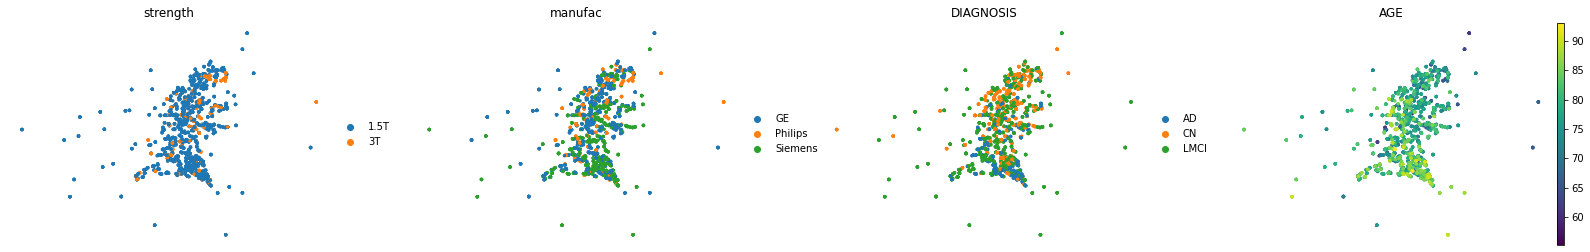

PCA


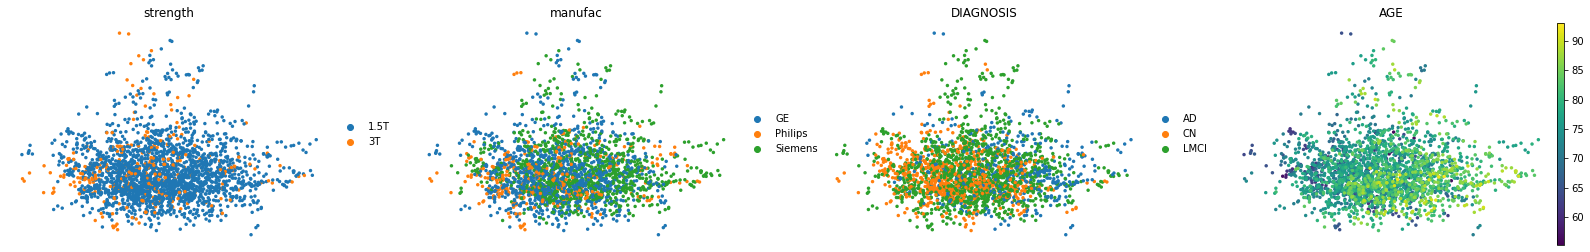

... storing 'ID' as categorical
... storing 'visit' as categorical
... storing 'EXAM_DATE' as categorical
... storing 'dateAcquired' as categorical
... storing 'SEX' as categorical
... storing 'DIAGNOSIS' as categorical
... storing 'manufac' as categorical
... storing 'manufac.model' as categorical
... storing 'manufac.model.site' as categorical
... storing 'manufac.model.strength.site' as categorical


Plots for: combat
UMAP


... storing 'manufac.model.coil.site' as categorical
... storing 'manufac.model.coil.strength.site' as categorical
... storing 'strength' as categorical
... storing 'Manufacturer' as categorical
... storing 'Mfg_Model' as categorical
... storing 'Weighting' as categorical
... storing 'Pulse_Sequence' as categorical
... storing 'Coil' as categorical
... storing 'Acquisition_Plane' as categorical


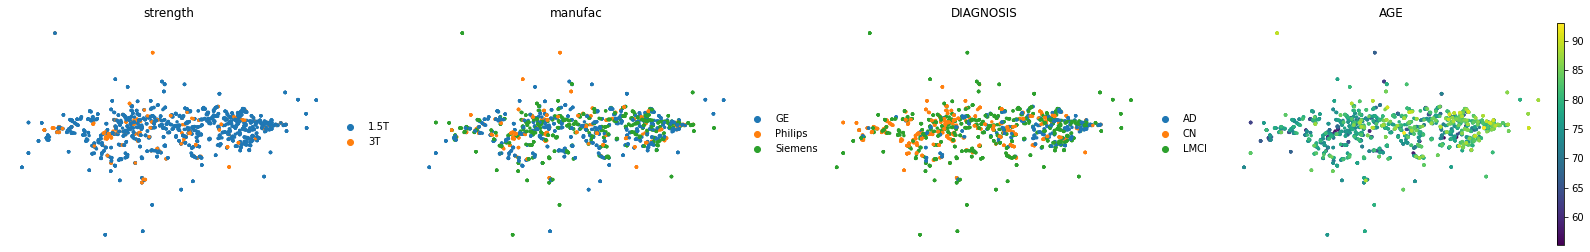

PCA


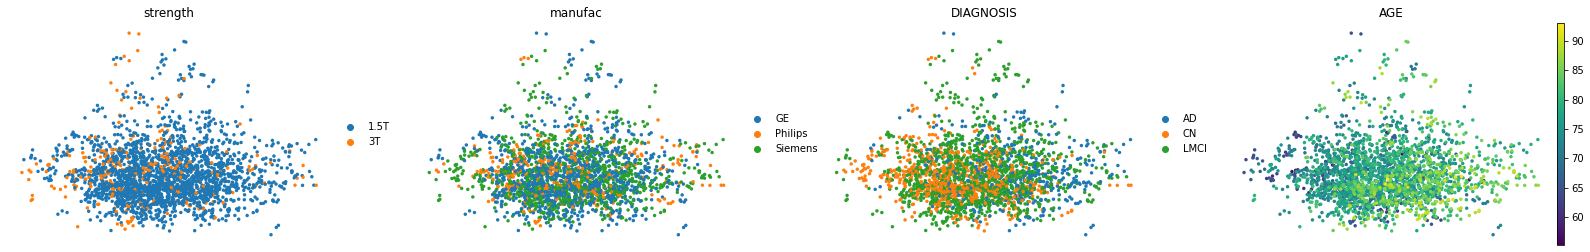

... storing 'ID' as categorical
... storing 'visit' as categorical
... storing 'EXAM_DATE' as categorical
... storing 'dateAcquired' as categorical
... storing 'SEX' as categorical
... storing 'DIAGNOSIS' as categorical
... storing 'manufac' as categorical
... storing 'manufac.model' as categorical
... storing 'manufac.model.site' as categorical
... storing 'manufac.model.strength.site' as categorical


Plots for: covbat
UMAP


... storing 'manufac.model.coil.site' as categorical
... storing 'manufac.model.coil.strength.site' as categorical
... storing 'strength' as categorical
... storing 'Manufacturer' as categorical
... storing 'Mfg_Model' as categorical
... storing 'Weighting' as categorical
... storing 'Pulse_Sequence' as categorical
... storing 'Coil' as categorical
... storing 'Acquisition_Plane' as categorical


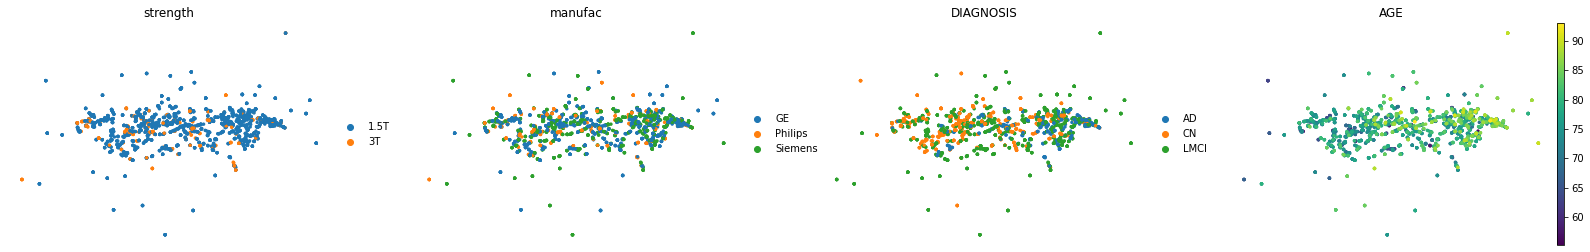

PCA


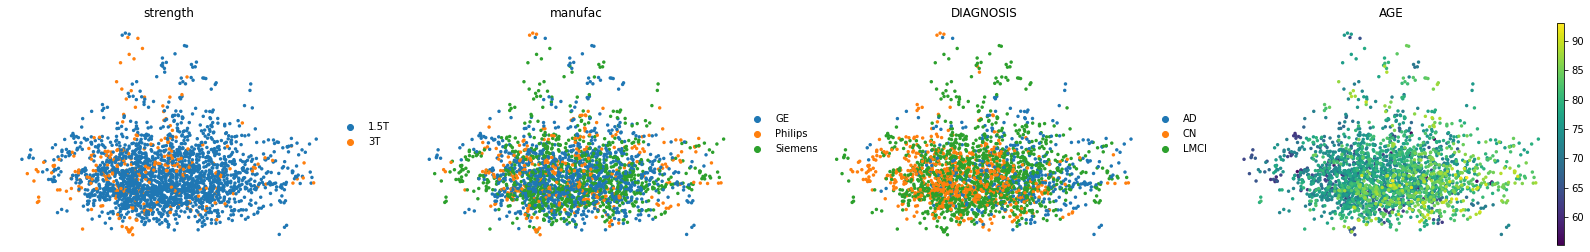

... storing 'ID' as categorical
... storing 'visit' as categorical
... storing 'EXAM_DATE' as categorical
... storing 'dateAcquired' as categorical
... storing 'SEX' as categorical
... storing 'DIAGNOSIS' as categorical
... storing 'manufac' as categorical
... storing 'manufac.model' as categorical
... storing 'manufac.model.site' as categorical
... storing 'manufac.model.strength.site' as categorical


Plots for: scvi_posterior
UMAP


... storing 'manufac.model.coil.site' as categorical
... storing 'manufac.model.coil.strength.site' as categorical
... storing 'strength' as categorical
... storing 'Manufacturer' as categorical
... storing 'Mfg_Model' as categorical
... storing 'Weighting' as categorical
... storing 'Pulse_Sequence' as categorical
... storing 'Coil' as categorical
... storing 'Acquisition_Plane' as categorical


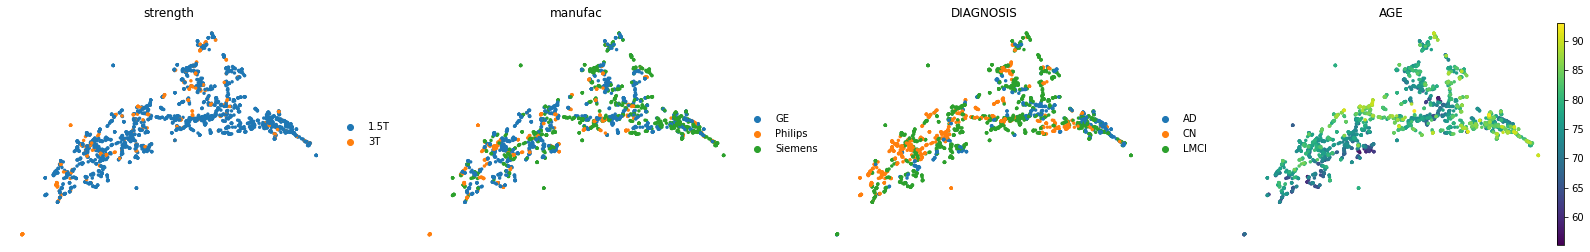

PCA


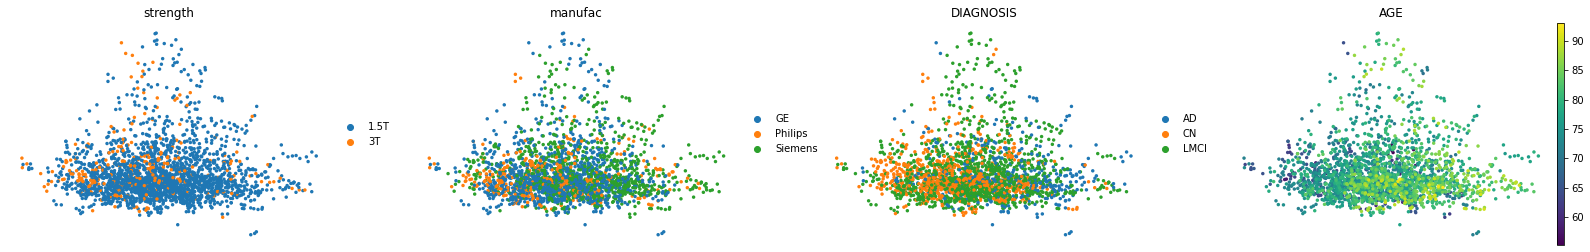

In [184]:
to_view = ["strength", "manufac", "DIAGNOSIS", "AGE"]
plot_pca_umap(adata, "raw", 0.02, color = to_view)
plot_pca_umap(adata, "combat", 0.02, color = to_view)
plot_pca_umap(adata, "covbat", 0.02, color = to_view)
plot_pca_umap(adata, "scvi_posterior", 0.02, color = to_view)

In [228]:
dill.dump_session("session.pkl")

SCVI Model with the following params: 
n_hidden: 128, n_latent: 20, n_layers: 2, dropout_rate: 0.1, dispersion: gene, 
gene_likelihood: nb, latent_distribution: normal
Training status: Trained

To print summary of associated AnnData, use: scvi.data.view_anndata_setup(model.adata)

TypeError: cannot pickle 'InstalledSTPackage' object

In [232]:
metrics_df.to_csv("metrics_df.csv")

In [233]:
metrics_df.rank(axis = 0, ascending = False).to_csv("metrics_rank.csv")